In [18]:
from ema_workbench import (Model, Policy, ema_logging, SequentialEvaluator, 
                           MultiprocessingEvaluator, Samplers)
from ema_workbench.em_framework.salib_samplers import get_SALib_problem
from SALib.analyze import sobol
from SALib.analyze.sobol import analyze
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

from dike_model_function import DikeNetwork
from custom_problem_formulation import get_model_for_problem_formulation

ema_logging.log_to_stderr(ema_logging.INFO)

<Logger EMA (DEBUG)>

In [3]:
dike_model, planning_steps = get_model_for_problem_formulation(3)

n_scenarios = 1000

policies= [Policy("No Policy", **dict({L.name: 0 for L in dike_model.levers}))]

with MultiprocessingEvaluator(dike_model) as evaluator:
    results = evaluator.perform_experiments(n_scenarios, policies=policies, uncertainty_sampling=Samplers.SOBOL)

experiments, outcomes = results
problem = get_SALib_problem(dike_model.uncertainties)

/Users/wouter/.pyenv/versions/3.12.2/envs/EPA141A_Model_Based_Decision_Making_Env/lib/python3.12/site-packages/ema_workbench/em_framework/__init__.py:101: UserWarning: ipyparallel not installed - IpyparalleEvaluator not available
  warnings.warn("ipyparallel not installed - IpyparalleEvaluator not available")
/Users/wouter/.pyenv/versions/3.12.2/envs/EPA141A_Model_Based_Decision_Making_Env/lib/python3.12/site-packages/ema_workbench/em_framework/__init__.py:101: UserWarning: ipyparallel not installed - IpyparalleEvaluator not available
  warnings.warn("ipyparallel not installed - IpyparalleEvaluator not available")
/Users/wouter/.pyenv/versions/3.12.2/envs/EPA141A_Model_Based_Decision_Making_Env/lib/python3.12/site-packages/ema_workbench/em_framework/__init__.py:101: UserWarning: ipyparallel not installed - IpyparalleEvaluator not available
  warnings.warn("ipyparallel not installed - IpyparalleEvaluator not available")
/Users/wouter/.pyenv/versions/3.12.2/envs/EPA141A_Model_Based_Decis

In [64]:
def plot_sobol_effects(problem, outcome_name, indices_data, confidence_intervals=None):
  """
  Plots Sobol effects (S1, ST) with optional confidence intervals.

  Args:
      problem: A dictionary containing problem information (assuming "names" key for variable names).
      outcome_name: The name of the outcome variable.
      indices_data: A dictionary containing S1, ST, and optionally S1_conf, ST_conf values.
      confidence_intervals: A boolean flag indicating if confidence intervals should be plotted (default: None).
  """
  variable_names = problem["names"]
  indices_df = pd.DataFrame(indices_data, index=variable_names)

  indices = indices_df[["S1", "ST"]]
  err = None if confidence_intervals is None else indices_df[["S1_conf", "ST_conf"]]

  fig, ax = plt.subplots(figsize=(8, 6))

  indices.plot.bar(yerr=err.values.T, ax=ax)

  # Graph setup
  plt.title(f'SOBOL on {outcome_name}')
  plt.xlabel('Uncertainties')
  plt.ylabel(f'{outcome_name}')
  plt.xticks(rotation=45, ha="right")  # Rotate x-axis labels for readability
  plt.tight_layout()
  plt.savefig(f'./images/SOBOL_{outcome_name}.png')  # Dynamic filename based on outcome
  plt.show()


/Users/wouter/.pyenv/versions/3.12.2/envs/EPA141A_Model_Based_Decision_Making_Env/lib/python3.12/site-packages/SALib/analyze/sobol.py:145: RuntimeWarning: invalid value encountered in divide
  Y = (Y - Y.mean()) / Y.std()


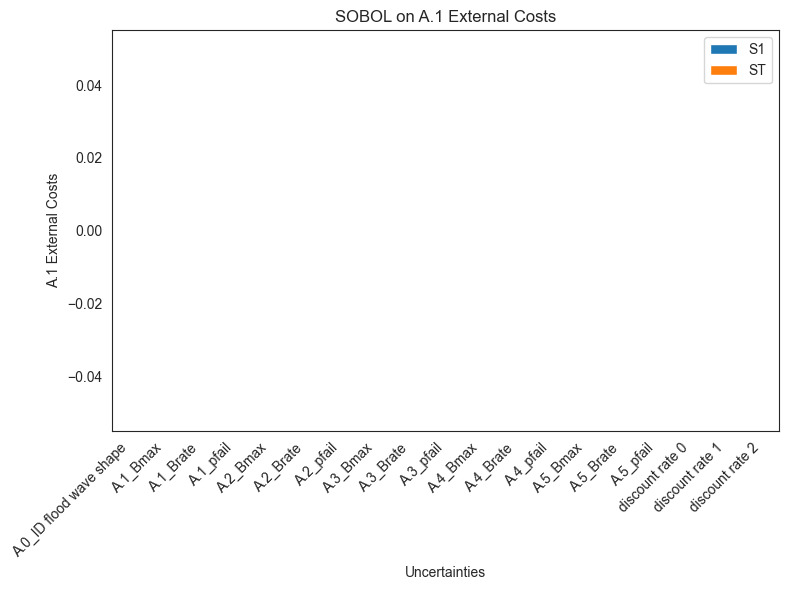

In [72]:
y = outcomes["A.1 External Costs"]
indices = analyze(problem, y, calc_second_order=True, print_to_console=False)

# Filter relevant Sobol indices (modify as needed)
scores_filtered = {"S1": indices["S1"], "ST": indices["ST"],
                   "S1_conf": indices.get("S1_conf", None),  # Include confidence intervals if available
                   "ST_conf": indices.get("ST_conf", None)} 

plot_sobol_effects(problem, "A.1 External Costs", scores_filtered, confidence_intervals=True)

/Users/wouter/.pyenv/versions/3.12.2/envs/EPA141A_Model_Based_Decision_Making_Env/lib/python3.12/site-packages/SALib/analyze/sobol.py:145: RuntimeWarning: invalid value encountered in divide
  Y = (Y - Y.mean()) / Y.std()


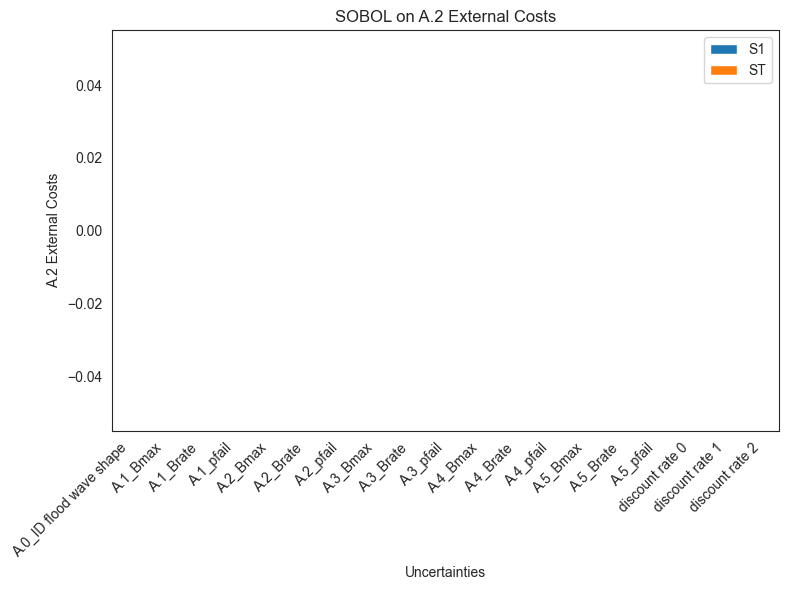

In [73]:
y = outcomes["A.2 External Costs"]
indices = analyze(problem, y, calc_second_order=True, print_to_console=False)

# Filter relevant Sobol indices (modify as needed)
scores_filtered = {"S1": indices["S1"], "ST": indices["ST"],
                   "S1_conf": indices.get("S1_conf", None),  # Include confidence intervals if available
                   "ST_conf": indices.get("ST_conf", None)} 

plot_sobol_effects(problem, "A.2 External Costs", scores_filtered, confidence_intervals=True)

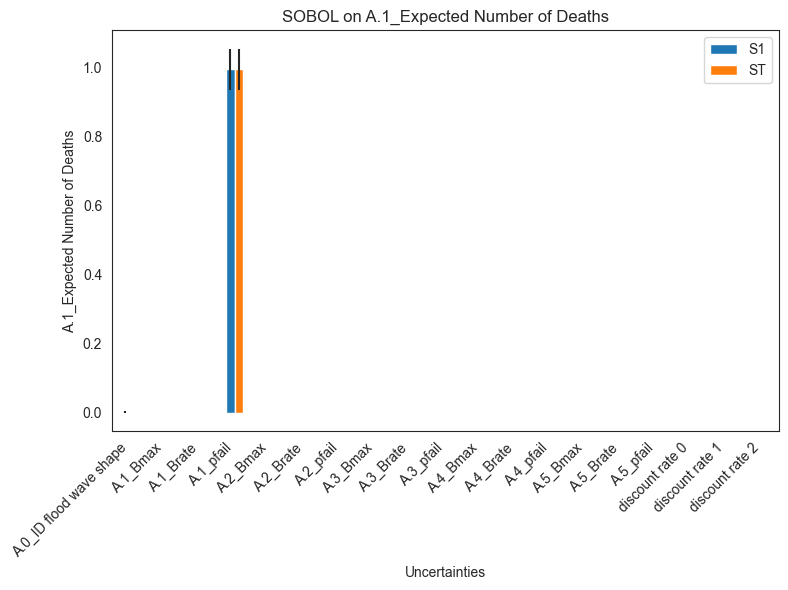

In [74]:
y = outcomes["A.1_Expected Number of Deaths"]
indices = analyze(problem, y, calc_second_order=True, print_to_console=False)

# Filter relevant Sobol indices (modify as needed)
scores_filtered = {"S1": indices["S1"], "ST": indices["ST"],
                   "S1_conf": indices.get("S1_conf", None),  # Include confidence intervals if available
                   "ST_conf": indices.get("ST_conf", None)} 

plot_sobol_effects(problem, "A.1_Expected Number of Deaths", scores_filtered, confidence_intervals=True)

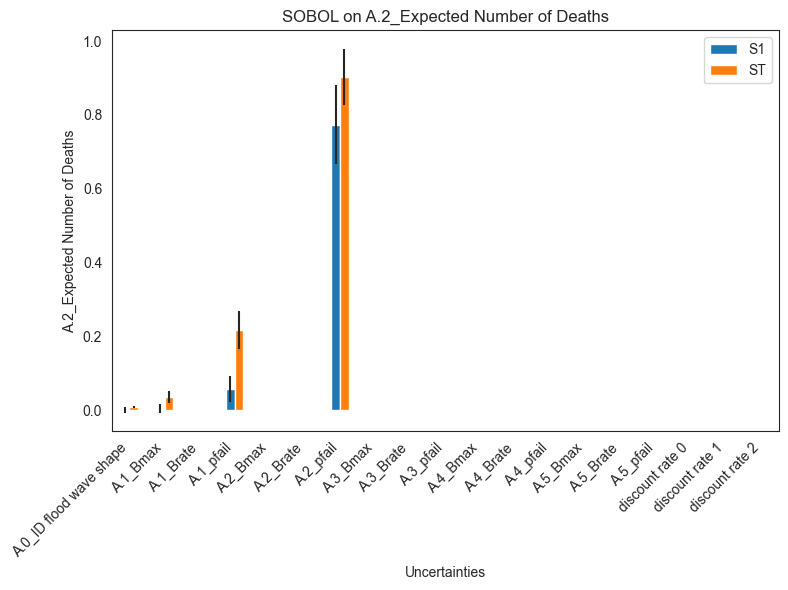

In [75]:
y = outcomes["A.2_Expected Number of Deaths"]
indices = analyze(problem, y, calc_second_order=True, print_to_console=False)

# Filter relevant Sobol indices (modify as needed)
scores_filtered = {"S1": indices["S1"], "ST": indices["ST"],
                   "S1_conf": indices.get("S1_conf", None),  # Include confidence intervals if available
                   "ST_conf": indices.get("ST_conf", None)} 

plot_sobol_effects(problem, "A.2_Expected Number of Deaths", scores_filtered, confidence_intervals=True)

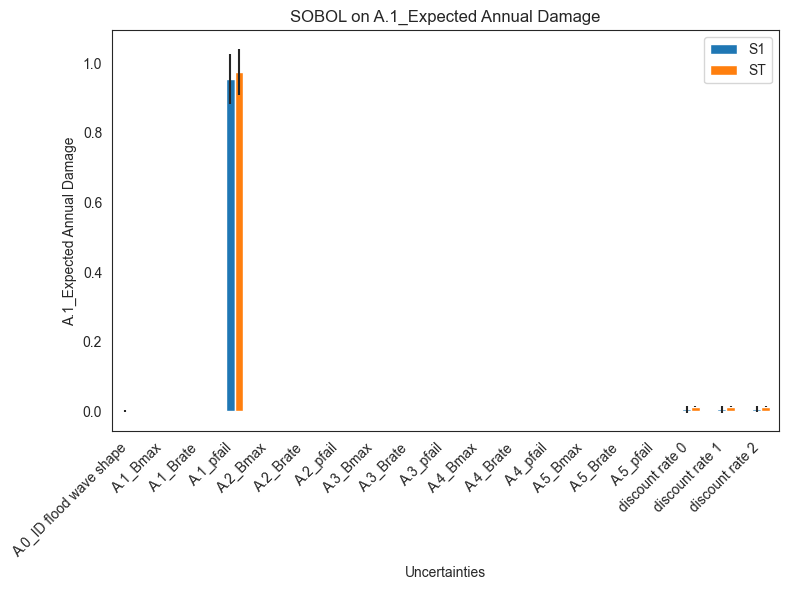

In [76]:
y = outcomes["A.1_Expected Annual Damage"]
indices = analyze(problem, y, calc_second_order=True, print_to_console=False)

# Filter relevant Sobol indices (modify as needed)
scores_filtered = {"S1": indices["S1"], "ST": indices["ST"],
                   "S1_conf": indices.get("S1_conf", None),  # Include confidence intervals if available
                   "ST_conf": indices.get("ST_conf", None)} 

plot_sobol_effects(problem, "A.1_Expected Annual Damage", scores_filtered, confidence_intervals=True)

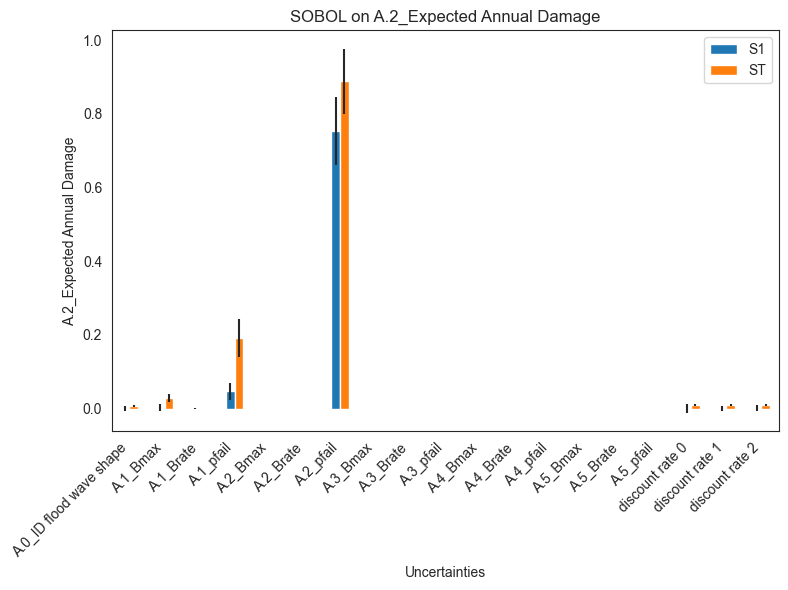

In [77]:
y = outcomes["A.2_Expected Annual Damage"]
indices = analyze(problem, y, calc_second_order=True, print_to_console=False)

# Filter relevant Sobol indices (modify as needed)
scores_filtered = {"S1": indices["S1"], "ST": indices["ST"],
                   "S1_conf": indices.get("S1_conf", None),  # Include confidence intervals if available
                   "ST_conf": indices.get("ST_conf", None)} 

plot_sobol_effects(problem, "A.2_Expected Annual Damage", scores_filtered, confidence_intervals=True)